# OCOM510M Data Science: Assessment 2

Student ID: 202031023

## 1. Aims, objectives and plan
Although we have already stated what is required, please formally state the aims and objectives of the project in your own words. 100-200 words.

Please demonstrate how you have conducted the project with a simple Gantt chart.

## 2. Understanding the case study

    ###  Case study analysis
State the key points that you found in the case and how you intend to deal with them appropriately to address the client's needs. (You can include more than four points.) 200-300 words.

1.
1. 
1. 
1. 



## 3. Pre-processing applied

**Create a new subheading for each stage that you do from the following items. Enter your code in the cells below the subheading.**

- Merging, pivoting and melting, if necessary
- Preparing the labels appropriately, if necessary
- Dealing with missing values (imputation, filtering) without leaking, if necessary
- Dealing with duplicate values, if necessary
- Scaling, without leaking, if necessary
- Dealing with correlation and collinearity, if necessary
- Variance analysis, if necessary
- Appropriate feature selection such as RFE, if necessary
- Appropriate feature extraction, if necessary
- Identifying and dealing with class imbalance, if necessary
- Identifying and dealing with outliers, if necessary
- Categorical and numerical encoding if necessary
- Other pre-processing

### Imports and reading data


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Reading data
In order to load the data we need to define the path


In [219]:
# Define all custom missing value indicators from the Attribute Information PDF
# This list will be passed to the 'na_values' parameter in pd.read_csv()
custom_na_values = [
    'NA',            # Found in InsuredGender, ContractType
    '-1',            # Found in PolicyAnnualPremium
    'MISSINGVAL',    # Found in TotalCharges
    '?',             # Found in TypeOfCollission, PropertyDamage, PoliceReport
    '-5',            # Found in IncidentTime (Hour)
    'MISSINGVALUE',  # Found in Witnesses
    'MISSEDDATA',    # Found in AmountOfTotalClaim
    '???'            # Found in VehicleAttributeDetails
]

# --- 2. Load the Datasets ---
data_dir = 'TrainData/'
demographics = pd.read_csv(data_dir + 'Train_Demographics.csv', na_values=custom_na_values)
claim = pd.read_csv(data_dir + 'Train_Claim.csv', na_values=custom_na_values)
policy = pd.read_csv(data_dir + 'Train_Policy.csv', na_values=custom_na_values)
target = pd.read_csv(data_dir + 'Traindata_with_Target.csv')

# The Vehicle file is in a long/tidy format (Attribute/Value pairs), which needs pivoting
vehicle_raw = pd.read_csv(data_dir + 'Train_Vehicle.csv', na_values=custom_na_values)

### Pivoting and melting

In [220]:
# Pivot the vehicle data from long to wide format
vehicle = vehicle_raw.pivot(
    index='CustomerID',
    columns='VehicleAttribute',
    values='VehicleAttributeDetails'
).reset_index()

# Rename columns to be clearer (optional, but good practice)
vehicle.columns.name = None
vehicle.rename(columns={'VehicleID': 'VehicleID_Value',
                        'VehicleMake': 'VehicleMake',
                        'VehicleModel': 'VehicleModel',
                        'VehicleYOM': 'VehicleYOM'},
               inplace=True)

vehicle.head()

,CustomerID,VehicleID_Value,VehicleMake,VehicleModel,VehicleYOM
0,Cust10000,Vehicle26917,Audi,A5,2008
1,Cust10001,Vehicle15893,Audi,A5,2006
2,Cust10002,Vehicle5152,Volkswagen,Jetta,1999
3,Cust10003,Vehicle37363,Volkswagen,Jetta,2003
4,Cust10004,Vehicle28633,Toyota,CRV,2010


In [177]:
def audit_merge(target_df, source_df):
    target_ids = set(target_df['CustomerID'])
    source_ids = set(source_df['CustomerID'])

    # 1. IDs in target_df but MISSING in source_df
    missing_in_demo = target_ids - source_ids

    # 2. IDs in source_df but MISSING in target_df
    missing_in_target = source_ids - target_ids

    # 3. The Intersection (IDs that exist in both)
    common_ids = target_ids.intersection(source_ids)

    # print(f"IDs in Target: {len(target_ids)}")
    # print(f"IDs in Source: {len(source_ids)}")
    # print(f"Common IDs: {len(common_ids)}")
    # print(f"Missing in Source: {len(missing_in_demo)}")
    # print(f"Missing in Target: {len(missing_in_target)}")

### Merging

In [221]:
# Start with the Target dataframe
data_merged = target.copy()

# Perform merges sequentially
# 1. Merge with Demographics
audit_merge(data_merged, demographics)
data_merged = data_merged.merge(demographics, on='CustomerID', how='inner')

# 2. Merge with Policy (Note: The policy file has its own PolicyNumber, but CustomerID is the key for the join)
audit_merge(data_merged, policy)
data_merged = data_merged.merge(policy, on='CustomerID', how='inner')

# 3. Merge with Claim data
audit_merge(data_merged, claim)
data_merged = data_merged.merge(claim, on='CustomerID', how='inner')

# 4. Merge with the Pivoted Vehicle data
audit_merge(data_merged, vehicle)
data_merged = data_merged.merge(vehicle, on='CustomerID', how='inner')

# print(f"Merged Dataset Shape: {data_merged.shape}")

# Convert 'ReportedFraud' (Target) to 1 (Fraud) and 0 (Genuine)
data_merged['ReportedFraud_Numeric'] = data_merged['ReportedFraud'].map({'Y': 1, 'N': 0})

# Drop the original 'ReportedFraud' column
data_merged.drop('ReportedFraud', axis=1, inplace=True)

# Check the first few rows and column information
data_merged.count()

# print("\n--- Data Types (Partial List) ---")
# print(data_merged.info(verbose=False))


CustomerID                    28836
InsuredAge                    28836
InsuredZipCode                28836
InsuredGender                 28806
InsuredEducationLevel         28836
InsuredOccupation             28836
InsuredHobbies                28836
CapitalGains                  28836
CapitalLoss                   28836
Country                       28834
InsurancePolicyNumber         28836
CustomerLoyaltyPeriod         28836
DateOfPolicyCoverage          28836
InsurancePolicyState          28836
Policy_CombinedSingleLimit    28836
Policy_Deductible             28836
PolicyAnnualPremium           28695
UmbrellaLimit                 28836
InsuredRelationship           28836
DateOfIncident                28836
TypeOfIncident                28836
TypeOfCollission              23674
SeverityOfIncident            28836
AuthoritiesContacted          26144
IncidentState                 28836
IncidentCity                  28836
IncidentAddress               28836
IncidentTime                

### Colinearity

A correlation analysis was performed on all numerical attributes. Significant collinearity was detected between AmountOfTotalClaim and its sub-components (AmountOfVehicleDamage, etc.). To address this, AmountOfTotalClaim was retained as the primary indicator of claim magnitude, while sub-components were monitored for redundancy. This simplifies the model and prevents coefficient instability in the Logistic Regression baseline.

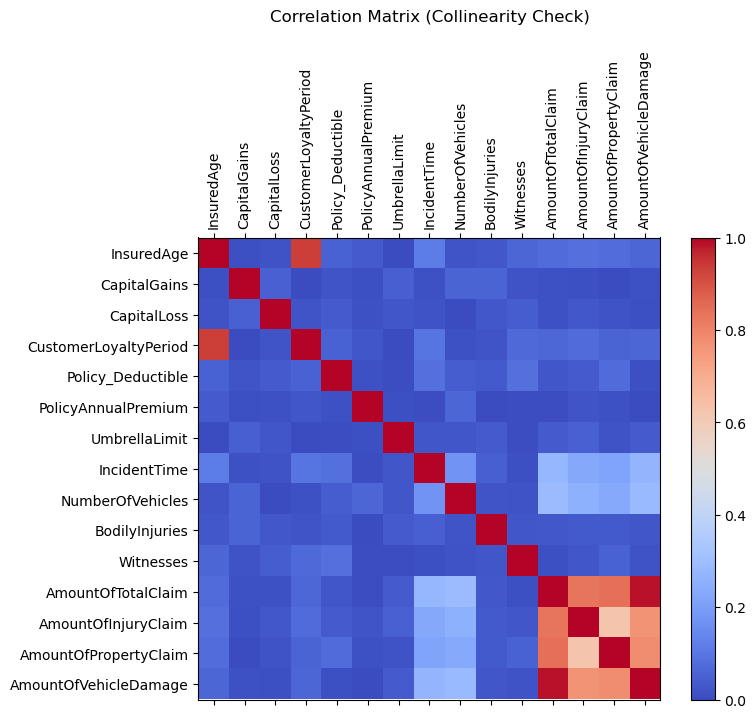

In [207]:
# 1. Calculate the correlation matrix (absolute values)
corr_matrix = X.select_dtypes(include=[np.number]).corr().abs()

# 2. Create the plot
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(corr_matrix, cmap='coolwarm', vmin=0, vmax=1)

# Add a colorbar
fig.colorbar(cax)

# Add labels
# Use range(len(columns)) to place ticks and rotation=90 for readability
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)

plt.title('Correlation Matrix (Collinearity Check)', pad=20)
plt.show()

### Removing noisy attributes
#### Removal of Noisy Attributes
"To improve model generalization and reduce overfitting, unique identifiers such as CustomerID, InsurancePolicyNumber, and VehicleID_Value were removed. These attributes contain high-cardinality data that does not possess predictive power for fraud detection. Additionally, IncidentAddress was excluded as the raw string data would act as noise without complex geospatial encoding."

#### Removal of Synonymous/Redundant Attributes:

"The attribute Country was identified as synonymous with a constant value (99.9% 'India') and thus removed due to lack of variance. Furthermore, raw date fields (DateOfPolicyCoverage, DateOfIncident) were removed to prevent redundancy, as temporal information is already captured in the CustomerLoyaltyPeriod and VehicleYOM attributes."

In [242]:
# 1. Final Drop List (Noisy + Synonymous + Highly Collinear)
# We drop the sub-claims because they are redundant with 'AmountOfTotalClaim'
cols_to_drop = [
    'CustomerID', 'InsurancePolicyNumber', 'InsuredZipCode',
    'IncidentAddress', 'VehicleID_Value', 'Country',
    'DateOfPolicyCoverage', 'DateOfIncident', 'VehicleModel',
    'AmountOfInjuryClaim', 'AmountOfPropertyClaim', 'AmountOfVehicleDamage'
]

# 2. Separate features and target
X = data_merged.drop(columns=cols_to_drop + ['ReportedFraud_Numeric'])
y = data_merged['ReportedFraud_Numeric']

# 3. Categorize for the Pipeline
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"Total features retained for Pipeline: {len(X.columns)}")

Total features retained for Pipeline: 29


### Building the "Master" Pipeline with Selection

In [243]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split

# A. Numerical Transformer (Impute + Scale)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# B. Categorical Transformer (Impute + One-Hot)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# C. Master Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# D. Create the 'Pre-Processing + Selection' Pipeline
# This ensures requirement 3.c (Feature Selection) is handled automatically
feature_selection_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', SelectKBest(score_func=f_classif, k=20)) # Automatically pick top 20
])

Splitting the Data

In [244]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Data split successfully. Train: {len(X_train)}, Test: {len(X_test)}")

Data split successfully. Train: 23068, Test: 5768


Technique 1 - Logistic Regression

In [246]:
from sklearn.linear_model import LogisticRegression

# Bundle everything together
pipeline_lr = Pipeline(steps=[
    ('prep_and_sel', feature_selection_pipeline),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

# TRAINING - This is where the protection happens!
pipeline_lr.fit(X_train, y_train)

print("Technique 1: Logistic Regression Pipeline trained without leakage.")

Technique 1: Logistic Regression Pipeline trained without leakage.


### Evaluation Metrics

--- Technique 1: Logistic Regression ---
Overall Accuracy: 80.74%

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86      4211
           1       0.62      0.75      0.68      1557

    accuracy                           0.81      5768
   macro avg       0.76      0.79      0.77      5768
weighted avg       0.82      0.81      0.81      5768



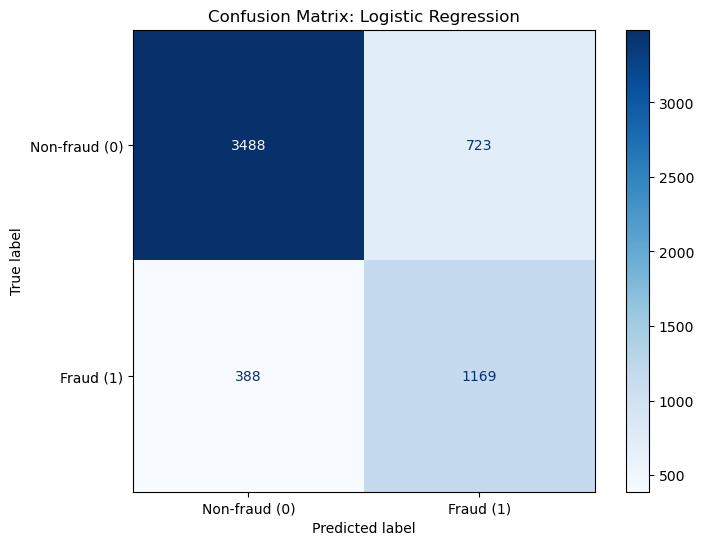

In [250]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay

# 1. Make predictions using the pipeline
y_pred = pipeline_lr.predict(X_test)

# 2. Calculate Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"--- Technique 1: Logistic Regression ---")
print(f"Overall Accuracy: {acc:.2%}")

# 3. Detailed Classification Report
# This gives you Precision, Recall, and F1-score
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 4. Generate the Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-fraud (0)', 'Fraud (1)'])

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', ax=ax)
plt.title('Confusion Matrix: Logistic Regression')
plt.show()

### Checking class imbalance


--- Class Imbalance Check (Percentage) ---
ReportedFraud_Numeric
0    73.002497
1    26.997503
Name: proportion, dtype: float64


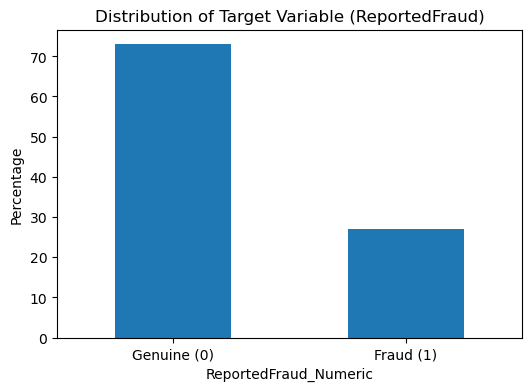

In [45]:
# Check for class imbalance
imbalance_check = data_merged['ReportedFraud_Numeric'].value_counts(normalize=True) * 100

print("\n--- Class Imbalance Check (Percentage) ---")
print(imbalance_check)

# Visualize the imbalance
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
imbalance_check.plot(kind='bar')
plt.title('Distribution of Target Variable (ReportedFraud)')
plt.xticks([0, 1], ['Genuine (0)', 'Fraud (1)'], rotation=0)
plt.ylabel('Percentage')
plt.show()

## 4. Technique 1
**Create a new subheading for each stage that you do from the following items. Enter your code in the cells below the subheading.**

- Motivation for choosing the technique and schematic figure of the analysis process (100-200 words)
- Setting hyperparameters (rationale)
- Optimising the hyperparameters appropriately
- Performance metrics for training set
- Other items necessary for the technique
- Deal with class imbalance, if necessary, if not done above

### 4.1 Motivation for choosing the technique and schematic figure of the analysis process

### Setting hyperparameters (rationale)

## 5. Technique 2
**Create a new subheading for each stage that you do from the following items. Enter your code in the cells below the subheading.**

- Motivation for choosing the technique and schematic figure of the analysis process (100-200 words)
- Setting hyperparameters (rationale)
- Optimising the hyperparameters appropriately
- Performance metrics for training set
- Other items necessary for the technique
- Deal with class imbalance, if necessary, if not done above

### 5.1 Motivation for choosing the technique and schematic figure of the analysis process

### Setting hyperparameters (rationale)

## 6. Comparison of metrics performance for testing

**Create a new subheading for each stage that you do from the following items. Enter your code in the cells below the subheading.**

- Use of nested cross-validation for both techniques to deal with overfitting model selection and model comparison
- Use appropriate metrics for the testing set
- Use an appropriate model selection visualisation curve (ROC, PR, etc.) that is suitable for the problem at hand
- Checking for overfitting

## 7. Final recommendation of the best model

**Create a new subheading for each item you discuss from the following items.**

- Technical perspective- overfitting discussion, complexity and efficiency
- Business perspective- results interpretation, relevance and balance with a technical perspective

## 8. Conclusion

**Create a new subheading for each item you discuss from the following items.**

- What has been successfully accomplished and what has not
- Reflect back on the analysis and see what you could have done differently if you were to do the project again
- Add a wish list of future work that you would do to take the project forward
